In [10]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True

import glob

## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy


from loading_function_flat10 import load_flat10, load_one_model, load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 

import dask
from dask import delayed, compute
from dask.distributed import Client


# Data and Metadata

In [11]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
# modellist=modellist_orig

# to match Sanderson paper:
modellist_ben=['ACCESS-ESM1-5',
                'CESM2',
                'GFDL-ESM4',
                'GISS_E2.1',
                'NorESM2-LM',
                'MPI-ESM1-2-LR',
                'CNRM-ESM2-1',
                'UKESM1.2',
                # 'UVic-ESCM-2-10',
                'HadCM3LC-Bris']

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
#varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

# modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']
# bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]
bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "gold"]

# -----select either original colors or ben's colors and order
modellist=modellist_ben
modelcolors=bencolors

latlist=['global','highlat','midlat','troplat']

markerlist=['o','v','^','<','>','s','*','P','d','X']


vegcolor=color=np.divide([176, 208, 65],255)
littercolor=np.divide([240, 155, 56],255)
soilcolor=np.divide([164, 119, 39],255)

subplotlabelnames=['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)']

In [12]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [13]:
def get_full_ts_flat10(modelname, exp, var, latrange):

    '''
    inputs (modelname, exp, var, latrange)
    outputs (VAR_ts) 
    
    # unit conversions need to be made after this is called
    # GPP_ts= GPP *  speryr #convert from Pg/s to Pg/yr
    # T_tszec = T-273.15
    # RH_tszec= RH *  speryr #convert from Pg/s to Pg/yr
    # NBP_tszec= NBP *  speryr #convert from Pg/s to Pg/yr
    
    '''
    timeseriesE=ds_C_global.sel(model=modelname, run='flat10', 
                                   var=var, latrange=latrange)
    
    timeseries=ds_C_global.sel(model=modelname, run=exp, 
                                   var=var, latrange=latrange)
    
    VAR_ts=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
    
    return VAR_ts


## Load data I made from global grids

In [14]:
# load timeseries of data
ds_C_global = xr.open_dataset("C_metrics_matrix_S.nc")

## Load global mean data from flat10MIP paper

In [15]:
# for UKESM and GISS, lets also load the global mean values from Ben's paper
bendatapath='/glade/work/aswann/jupyter_notebooks/esm-deck/ESM_data/'

In [16]:
data_dict_global={}

In [74]:
modellist=modellist_orig

varlist=['nbp','cVeg','cSoil']
#----loop over models----#
for m in range(len(modellist)):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for r in range(len(runlist)):
        run = runlist_wc[r]
        print('loading run: ' +run)
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            print('loading variable: ' +var)
            
            searchpath= bendatapath  +model +'/' +run +'_' +var +'_' +model +'.nc'
            if (model =='GISS_E2.1'):
                modelw='GISS'
                searchpath= bendatapath  +modelw +'/' +run +'_' +var +'_' +modelw +'.nc'
            if (model == 'UKESM1.2'):
                modelw='UKESM'
                searchpath= bendatapath  +modelw +'/' +run +'_' +var +'_' +modelw +'.nc'
            if model=='CESM2':
                if var=='cVeg':
                    varw='cveg'
                    searchpath= bendatapath  +model +'/' +run +'_' +varw +'_' +model +'.nc'
                if var=='cSoil':
                    varw='csoil'
                    searchpath= bendatapath  +model +'/' +run +'_' +varw +'_' +model +'.nc'

            filename= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim
            
            if filename.size==0:
                continue
            else:
                # print(file)
                file=filename[0]
                dsmerge_f = xr.open_dataset(file)
                
            
            # #----merge all variables into one dataset----#
            # # if it's the first variable, then start a new datset, otherwise merge with existing
            # if v ==0:
            #     dsmerge_v = dsmerge_f.copy()
            # else:
            #     dsmerge_v=xr.merge([dsmerge_v, dsmerge_f],compat='override')    
       
            #----save output to a dictionary----#
            print('adding ' +model +' ' +runlist[r] +' to dict')
            data_dict_global[model +'_' +runlist[r] +'_' +var] = dsmerge_f

loading model: ACCESS-ESM1-5
loading run: *lat10
loading variable: nbp
adding ACCESS-ESM1-5 flat10 to dict
loading variable: cVeg
adding ACCESS-ESM1-5 flat10 to dict
loading variable: cSoil
adding ACCESS-ESM1-5 flat10 to dict
loading run: *zec
loading variable: nbp
adding ACCESS-ESM1-5 flat10_zec to dict
loading variable: cVeg
adding ACCESS-ESM1-5 flat10_zec to dict
loading variable: cSoil
adding ACCESS-ESM1-5 flat10_zec to dict
loading run: *cdr
loading variable: nbp
adding ACCESS-ESM1-5 flat10_cdr to dict
loading variable: cVeg
adding ACCESS-ESM1-5 flat10_cdr to dict
loading variable: cSoil
adding ACCESS-ESM1-5 flat10_cdr to dict
loading model: CESM2
loading run: *lat10
loading variable: nbp
adding CESM2 flat10 to dict
loading variable: cVeg
adding CESM2 flat10 to dict
loading variable: cSoil
adding CESM2 flat10 to dict
loading run: *zec
loading variable: nbp
adding CESM2 flat10_zec to dict
loading variable: cVeg
adding CESM2 flat10_zec to dict
loading variable: cSoil
adding CESM2 fl

/glade/derecho/scratch/aswann/tmp/ipykernel_68114/4185315218.py:39: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  dsmerge_f = xr.open_dataset(file)
/glade/derecho/scratch/aswann/tmp/ipykernel_68114/4185315218.py:39: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  dsmerge_f = xr.open_dataset(file)
/glade/derecho/scratch/aswann/tmp/ipykernel_68114/4185315218.py:39: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  dsmerge_f = xr.open_datase

adding NorESM2-LM flat10 to dict
loading variable: cSoil
adding NorESM2-LM flat10 to dict
loading run: *zec
loading variable: nbp
adding NorESM2-LM flat10_zec to dict
loading variable: cVeg
adding NorESM2-LM flat10_zec to dict
loading variable: cSoil
adding NorESM2-LM flat10_zec to dict
loading run: *cdr
loading variable: nbp
adding NorESM2-LM flat10_cdr to dict
loading variable: cVeg
adding NorESM2-LM flat10_cdr to dict
loading variable: cSoil
adding NorESM2-LM flat10_cdr to dict
loading model: MPI-ESM1-2-LR
loading run: *lat10
loading variable: nbp
adding MPI-ESM1-2-LR flat10 to dict
loading variable: cVeg
loading variable: cSoil
loading run: *zec
loading variable: nbp
adding MPI-ESM1-2-LR flat10_zec to dict
loading variable: cVeg
loading variable: cSoil
loading run: *cdr
loading variable: nbp
adding MPI-ESM1-2-LR flat10_cdr to dict
loading variable: cVeg
loading variable: cSoil
loading model: CNRM-ESM2-1
loading run: *lat10
loading variable: nbp
adding CNRM-ESM2-1 flat10 to dict
loa

/glade/derecho/scratch/aswann/tmp/ipykernel_68114/4185315218.py:39: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  dsmerge_f = xr.open_dataset(file)
/glade/derecho/scratch/aswann/tmp/ipykernel_68114/4185315218.py:39: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  dsmerge_f = xr.open_dataset(file)
/glade/derecho/scratch/aswann/tmp/ipykernel_68114/4185315218.py:39: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  dsmerge_f = xr.open_datase

adding CNRM-ESM2-1 flat10_zec to dict
loading run: *cdr
loading variable: nbp
adding CNRM-ESM2-1 flat10_cdr to dict
loading variable: cVeg
adding CNRM-ESM2-1 flat10_cdr to dict
loading variable: cSoil
adding CNRM-ESM2-1 flat10_cdr to dict
loading model: HadCM3LC-Bris
loading run: *lat10
loading variable: nbp
adding HadCM3LC-Bris flat10 to dict
loading variable: cVeg
loading variable: cSoil
loading run: *zec
loading variable: nbp
adding HadCM3LC-Bris flat10_zec to dict
loading variable: cVeg
loading variable: cSoil
loading run: *cdr
loading variable: nbp
adding HadCM3LC-Bris flat10_cdr to dict
loading variable: cVeg
loading variable: cSoil
loading model: UKESM1.2
loading run: *lat10
loading variable: nbp
adding UKESM1.2 flat10 to dict
loading variable: cVeg
loading variable: cSoil
loading run: *zec
loading variable: nbp
adding UKESM1.2 flat10_zec to dict
loading variable: cVeg
loading variable: cSoil
loading run: *cdr
loading variable: nbp
adding UKESM1.2 flat10_cdr to dict
loading vari

In [73]:
filename

array([], dtype=float64)

## plot

In [44]:
model

'HadCM3LC-Bris'

In [45]:
flat10=data_dict_global[model +'_' +'flat10_zec']
flat10

<xarray.Dataset> Size: 42kB
Dimensions:         (time: 2640, bnds: 2)
Coordinates:
  * time            (time) object 21kB 1951-01-17 00:00:00 ... 2170-12-17 00:...
    latitude        float32 4B ...
    longitude       float32 4B ...
    surface         float32 4B ...
Dimensions without coordinates: bnds
Data variables:
    unknown         (time) float64 21kB ...
    latitude_bnds   (bnds) float32 8B ...
    longitude_bnds  (bnds) float64 16B ...
Attributes:
    date:                   00/12/50
    invalid_standard_name:  none
    pcmdi_name:             none
    processing:             monthly_mean_at_surface
    source:                 Unified Model Output (Vn 4.6):
    submodel:               1
    time:                   00:00
    Conventions:            CF-1.7

loading model: ACCESS-ESM1-5
loading model: CESM2
loading model: GFDL-ESM4
loading model: GISS_E2.1
loading model: NorESM2-LM
loading model: MPI-ESM1-2-LR
loading model: CNRM-ESM2-1
loading model: HadCM3LC-Bris
loading model: UKESM1.2


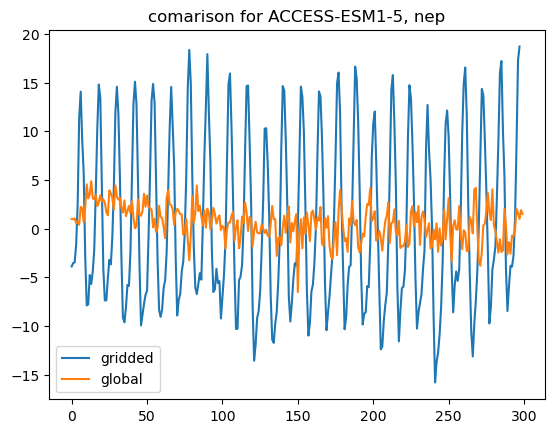

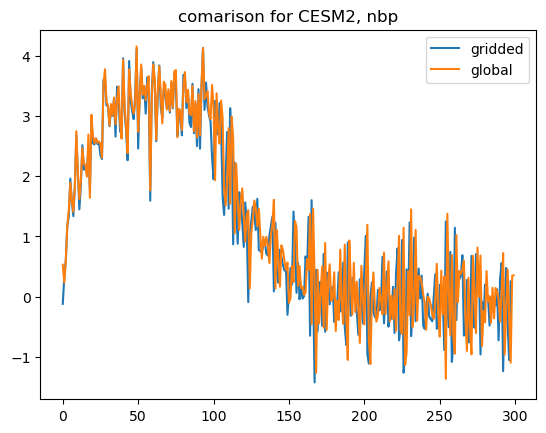

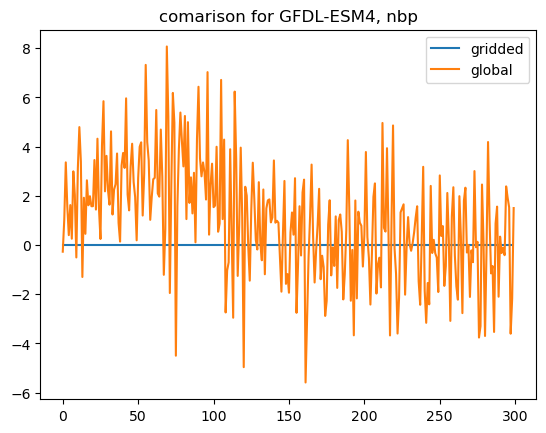

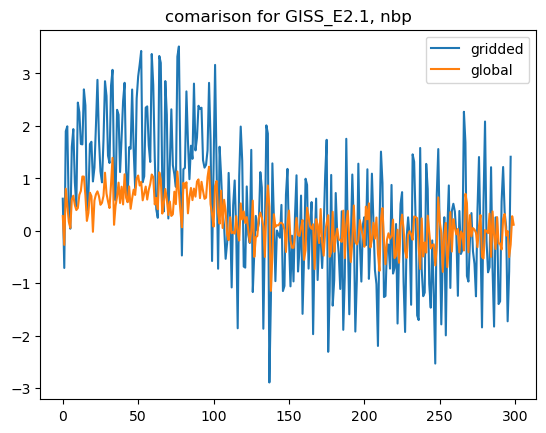

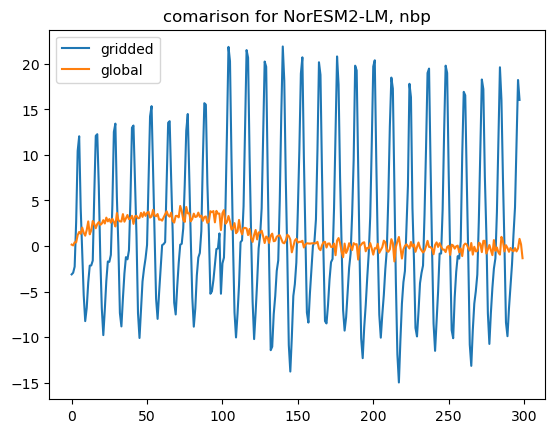

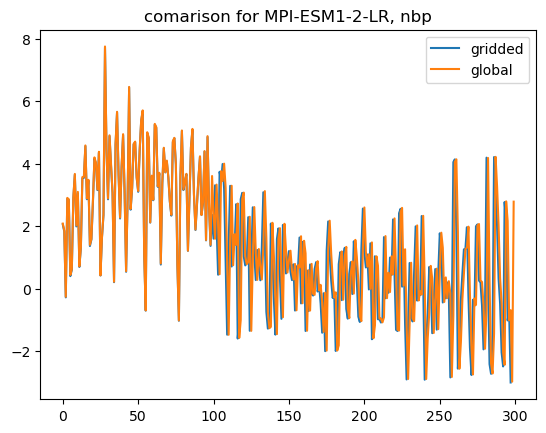

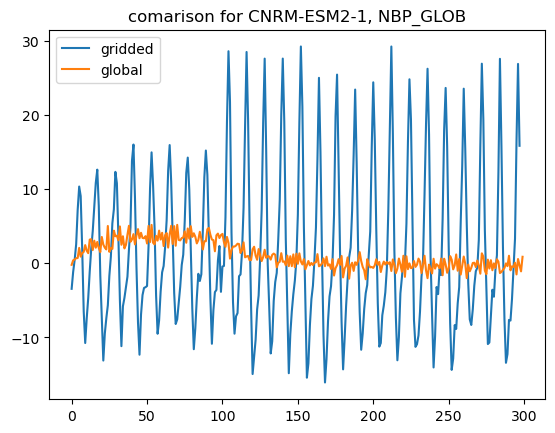

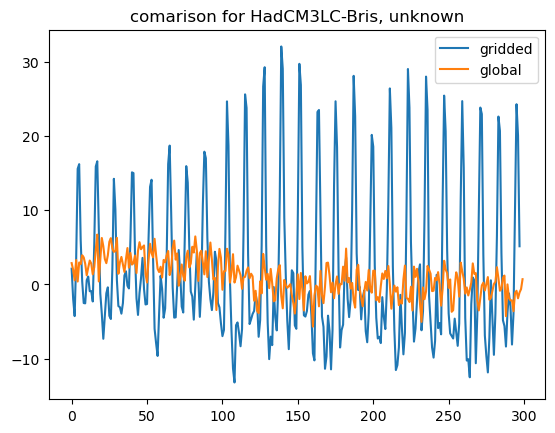

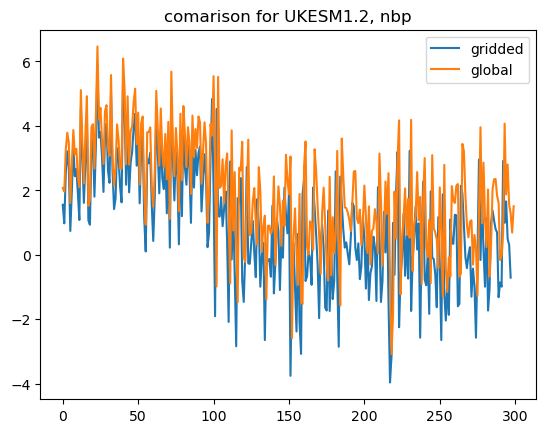

In [78]:

#----loop over models----#
for m in range(len(modellist)):
    model=modellist[m]
    print('loading model: ' +model)
    fig, axes = plt.subplots(1,1)#,figsize=(, 8))


    var='nbp'
    unitconvert=1
    
    flat10=data_dict_global[model +'_' +'flat10' +'_' +var]
    flat10zec=data_dict_global[model +'_' +'flat10_zec' +'_' +var]

    if model=='UKESM1.2':
        unitconvert=5.1e14/1e12*.29
    if model=='ACCESS-ESM1-5':
        var='nep'
    if model=='CNRM-ESM2-1':
        var='NBP_GLOB'
    if model=='HadCM3LC-Bris':
        var='unknown'
    if model=='CESM2':
        unitconvert=1e-15
    
    ts=np.append(flat10[var][0:99].values,flat10zec[var][0:199].values)

    # plt.plot(np.cumsum(ts))
    
    plt.plot(ts*unitconvert,label='gridded')
    
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', 'global')
    plt.plot(NBPo*speryr,label='global')
    plt.title('comarison for ' +model +', ' +var)
    plt.legend()

loading model: ACCESS-ESM1-5
loading model: CESM2
loading model: GFDL-ESM4
loading model: GISS_E2.1
loading model: NorESM2-LM
loading model: MPI-ESM1-2-LR
loading model: CNRM-ESM2-1
loading model: HadCM3LC-Bris
loading model: UKESM1.2


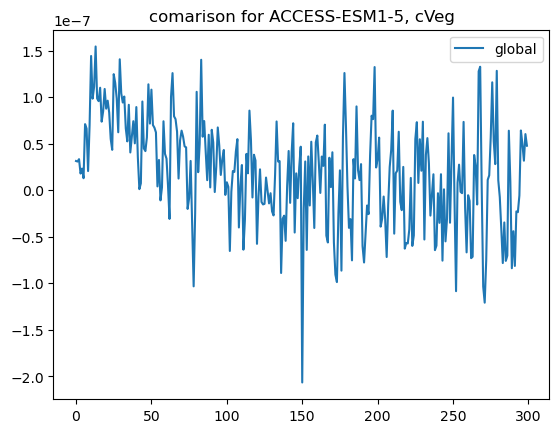

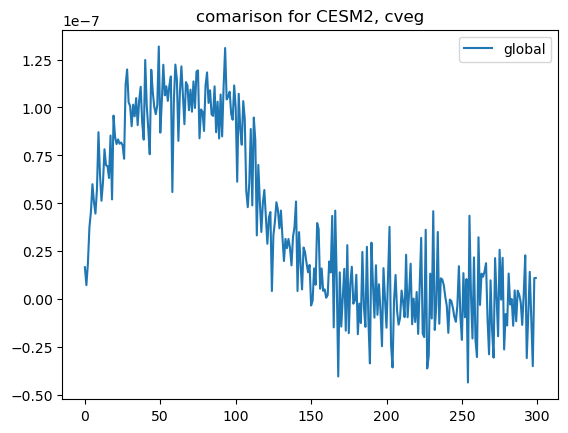

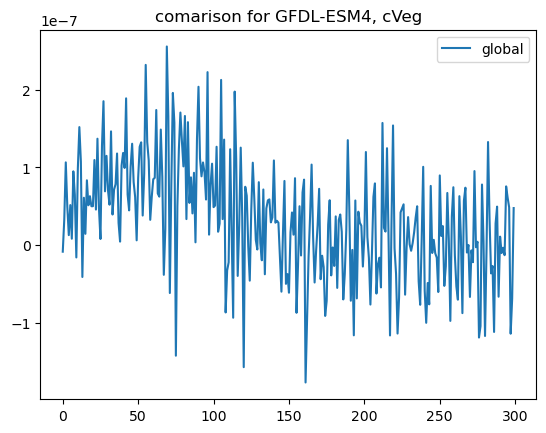

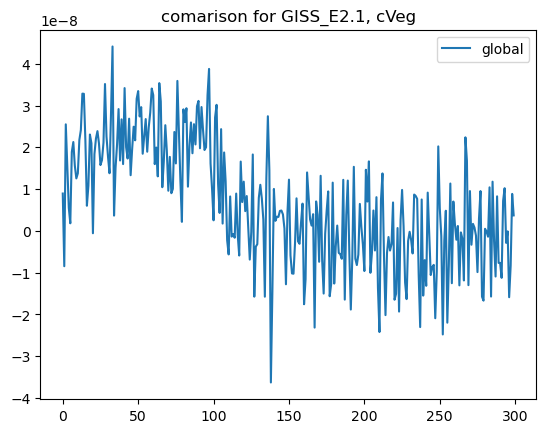

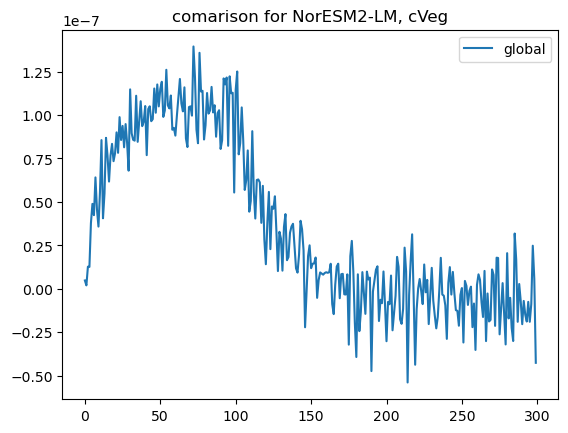

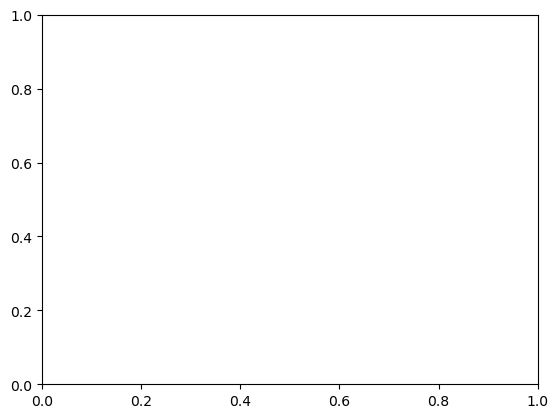

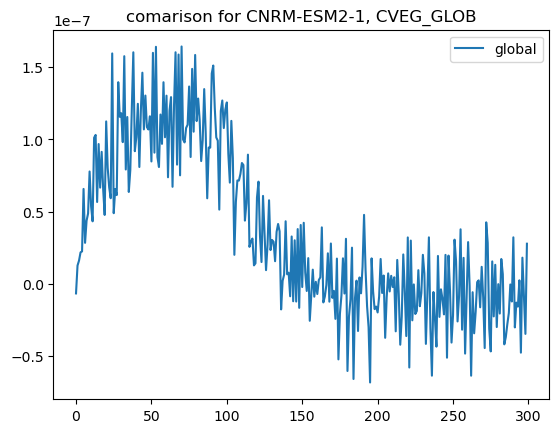

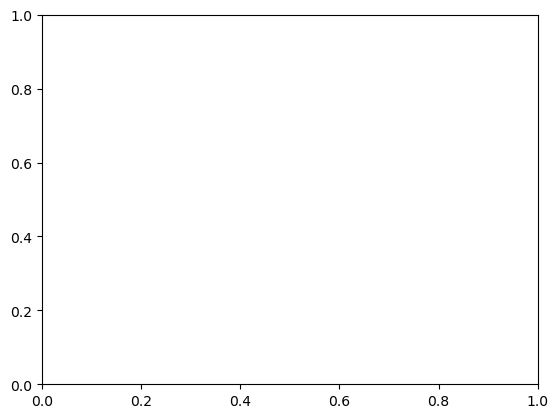

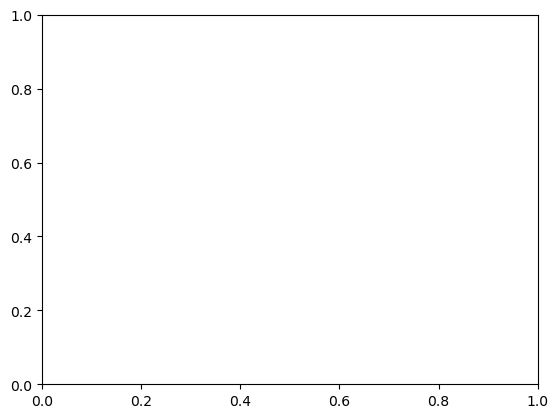

In [83]:

#----loop over models----#
for m in range(len(modellist)):
    model=modellist[m]
    print('loading model: ' +model)
    fig, axes = plt.subplots(1,1)#,figsize=(, 8))


    var='cVeg'
    unitconvert=1

    try:
        flat10=data_dict_global[model +'_' +'flat10' +'_' +var]
        flat10zec=data_dict_global[model +'_' +'flat10_zec' +'_' +var]
    except:
        continue

    # if model=='UKESM1.2':
    #     unitconvert=5.1e14/1e12*.29
    # if model=='ACCESS-ESM1-5':
    #     var='nep'
    if model=='CNRM-ESM2-1':
        var='CVEG_GLOB'
    # if model=='HadCM3LC-Bris':
    #     var='unknown'
    if model=='CESM2':
        var='cveg'
        unitconvert=1e-15
    
    ts=np.append(flat10[var][0:99].values,flat10zec[var][0:199].values)

    # plt.plot(np.cumsum(ts))
    
    # plt.plot(ts*unitconvert,label='gridded')
    
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', 'global')
    plt.plot(NBPo,label='global')
    plt.title('comarison for ' +model +', ' +var)
    plt.legend()

In [ ]:

UKESM_flat10_nbp=5.1e14/1e12*.29*xr.open_dataset(bendatapath +'UKESM/flat10_nbp_UKESM.nc')
UKESM_flat10zec_nbp=5.1e14/1e12*.29*xr.open_dataset(bendatapath +'UKESM/flat10-zec_nbp_UKESM.nc')
UKESM_flat10cdr_nbp=5.1e14/1e12*.29*xr.open_dataset(bendatapath +'UKESM/flat10-cdr_nbp_UKESM.nc')

# np.append(UKESM_flat10_nbp.nbp[0:100].values,UKESM_flat10zec_nbp.nbp[0:200].values)

GISS_flat10_nbp=xr.open_dataset(bendatapath +'GISS/flat10_nbp_GISS.nc')
GISS_flat10zec_nbp=xr.open_dataset(bendatapath +'GISS/flat10-zec_nbp_GISS.nc')
GISS_flat10cdr_nbp=xr.open_dataset(bendatapath +'GISS/flat10-cdr_nbp_GISS.nc')

# np.append(GISS_flat10_nbp.nbp[0:100].values,GISS_flat10zec_nbp.nbp[0:200].values)

In [ ]:
# for UKESM and GISS, lets also load the global mean values from Ben's paper
bendatapath='/glade/work/aswann/jupyter_notebooks/esm-deck/ESM_data/'



UKESM_flat10_nbp=5.1e14/1e12*.29*xr.open_dataset(bendatapath +'UKESM/flat10_nbp_UKESM.nc')
UKESM_flat10zec_nbp=5.1e14/1e12*.29*xr.open_dataset(bendatapath +'UKESM/flat10-zec_nbp_UKESM.nc')
UKESM_flat10cdr_nbp=5.1e14/1e12*.29*xr.open_dataset(bendatapath +'UKESM/flat10-cdr_nbp_UKESM.nc')

# np.append(UKESM_flat10_nbp.nbp[0:100].values,UKESM_flat10zec_nbp.nbp[0:200].values)

GISS_flat10_nbp=xr.open_dataset(bendatapath +'GISS/flat10_nbp_GISS.nc')
GISS_flat10zec_nbp=xr.open_dataset(bendatapath +'GISS/flat10-zec_nbp_GISS.nc')
GISS_flat10cdr_nbp=xr.open_dataset(bendatapath +'GISS/flat10-cdr_nbp_GISS.nc')

# np.append(GISS_flat10_nbp.nbp[0:100].values,GISS_flat10zec_nbp.nbp[0:200].values)


In [ ]:
# ts=np.append(UKESM_flat10_nbp.nbp[0:99].values,UKESM_flat10zec_nbp.nbp[0:199].values)
ts=np.append(GISS_flat10_nbp.nbp[0:100].values,GISS_flat10zec_nbp.nbp[0:200].values)

# plt.plot(np.cumsum(ts))

plt.plot(ts,label='gridded')

NBPo= get_full_ts_flat10('GISS_E2.1', 'flat10_zec', 'nbp', 'global')
plt.plot(NBPo*speryr,label='global')
plt.title('GISS NBP comarison')
plt.legend()

In [ ]:
ts=np.append(UKESM_flat10_nbp.nbp[0:99].values,UKESM_flat10zec_nbp.nbp[0:199].values)
# ts=np.append(GISS_flat10_nbp.nbp[0:100].values,GISS_flat10zec_nbp.nbp[0:200].values)

# plt.plot(np.cumsum(ts))

plt.plot(ts,label='gridded')

NBPo= get_full_ts_flat10('UKESM1.2', 'flat10_zec', 'nbp', 'global')
plt.plot(NBPo*speryr,label='global')
plt.title('UKESM NBP comparison')
plt.legend()

In [ ]:
CESM2_flat10_nbp=xr.open_dataset(bendatapath +'CESM2/flat10_nbp_CESM2.nc')
CESM2_flat10zec_nbp=xr.open_dataset(bendatapath +'CESM2/flat10-zec_nbp_CESM2.nc')
CESM2_flat10cdr_nbp=xr.open_dataset(bendatapath +'CESM2/flat10-cdr_nbp_CESM2.nc')


ts=np.append(CESM2_flat10_nbp.nbp[0:99].values,CESM2_flat10zec_nbp.nbp[0:199].values)
# ts=np.append(GISS_flat10_nbp.nbp[0:100].values,GISS_flat10zec_nbp.nbp[0:200].values)

# plt.plot(np.cumsum(ts))

plt.plot(ts*1e-15,label='gridded')

NBPo= get_full_ts_flat10('CESM2', 'flat10_zec', 'nbp', 'global')
plt.plot(NBPo*speryr,label='global')
plt.title('CESM2 NBP comparison')
plt.legend()